In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/witcher-books/data/1 The Last Wish.txt
/kaggle/input/witcher-books/data/7 The Lady of the Lake.txt
/kaggle/input/witcher-books/data/8 something ends something begins.txt
/kaggle/input/witcher-books/data/3 Blood of Elves.txt
/kaggle/input/witcher-books/data/2 The Sword of Destiny.txt
/kaggle/input/witcher-books/data/6 The Tower of the Swallow.txt
/kaggle/input/witcher-books/data/4 Times of Contempt.txt
/kaggle/input/witcher-books/data/5 Baptism of Fire.txt
/kaggle/input/witcher-book-characters/characters.csv


# Libraries

In [4]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [5]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.8 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")

# Load books

In [17]:
import os
 
# Get all book files in the data directory
all_books = [b for b in os.scandir('/kaggle/input/witcher-books/data') if '.txt' in b.name]

In [18]:
all_books

[<DirEntry '1 The Last Wish.txt'>,
 <DirEntry '7 The Lady of the Lake.txt'>,
 <DirEntry '8 something ends something begins.txt'>,
 <DirEntry '3 Blood of Elves.txt'>,
 <DirEntry '2 The Sword of Destiny.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '4 Times of Contempt.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>]

In [6]:
all_books = pd.read_csv("/kaggle/input/witcher-book-characters/characters.csv")

In [12]:
all_books

,book,character
0,Category:Baptism of Fire characters,Adalia
1,Category:Baptism of Fire characters,Adela
2,Category:Baptism of Fire characters,Aen Saevherne
3,Category:Baptism of Fire characters,Aevenien
4,Category:Baptism of Fire characters,Aglaïs
...,...,...
1270,Category:Time of Contempt characters,Yanna of Murivel
1271,Category:Time of Contempt characters,Yarpen Zigrin
1272,Category:Time of Contempt characters,Yennefer of Vengerberg
1273,Category:Time of Contempt characters,Yiolenta Suarez


In [19]:
book = all_books[1]
book_text = open(book).read()
book_doc = NER(book_text)

In [20]:
# Visualize identified entities
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

# Load character names

In [22]:
# Read characters
character_df = pd.read_csv("/kaggle/input/witcher-book-characters/characters.csv")

In [23]:
# Remove brackets and text within brackets
import re 
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x)) 
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [25]:
pd.set_option('display.max_rows', None)
character_df.head()

,book,character,character_firstname
0,Category:Baptism of Fire characters,Adalia,Adalia
1,Category:Baptism of Fire characters,Adela,Adela
2,Category:Baptism of Fire characters,Aen Saevherne,Aen
3,Category:Baptism of Fire characters,Aevenien,Aevenien
4,Category:Baptism of Fire characters,Aglaïs,Aglaïs


# Get named entity list per sentence

In [34]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [35]:
sent_entity_df.head(10)

,sentence,entities
0,"( \n, THE, LADY, OF, THE, LAKE, \n \n \n\n, Th...",[Arthur]
1,"(', Behold, ,, there, is, the, sword, of, whic...","[Behold, Merlin]"
2,"(Suddenly, they, saw, a, girl, walking, on, th...",[]
3,"(', Who, is, that, girl, ?, ', asked, Arthur, ...",[Arthur]
4,"(', That, is, the, Lady, of, the, Lake, ,, ', ...",[Merlin]
5,"(Sir, Thomas, Malory, \n, Le, Morte, Darthur, ...","[Thomas Malory, Le Morte Darthur, Chapter One]"
6,"(The, lake, was, enchanted, .)",[]
7,"(About, that, there, could, be, no, doubt, ., \n)",[]
8,"(Firstly, :, it, lay, beside, the, mouth, of, ...","[Firstly, Cwm Pwcca]"
9,"(Secondly, :, one, look, was, enough, ., \n)","[Secondly, one]"


In [38]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [39]:
filter_entity(["Geralt", "Thu", "2"], character_df)

['Geralt']

In [40]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

# Filter out sentences that don't have any character entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

,sentence,entities,character_entities
0,"( \n, THE, LADY, OF, THE, LAKE, \n \n \n\n, Th...",[Arthur],[Arthur]
1,"(', Behold, ,, there, is, the, sword, of, whic...","[Behold, Merlin]",[Merlin]
3,"(', Who, is, that, girl, ?, ', asked, Arthur, ...",[Arthur],[Arthur]
4,"(', That, is, the, Lady, of, the, Lake, ,, ', ...",[Merlin],[Merlin]
133,"(I, 'm, sorry, ,, \n, Galahad, or, whatever, y...",[Galahad],[Galahad]
137,"(', But, yet, ,, ', he, dared, to, say, ,, ', ...","[Faerie, Lady]",[Lady]
145,"(Kelpie, ...)",[Kelpie],[Kelpie]
161,"(Do, you, have, anything, to, eat, ,, Galahad, ?)",[Galahad],[Galahad]
169,"(In, a, world, in, \n, which, I, search, in, v...",[Seven],[Seven]
183,"(Despite, knowing, this, ,, \n, Galahad, could...",[Galahad],[Galahad]


In [41]:
# Take only first name of characters
sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

/tmp/ipykernel_32/364234938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]


In [42]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
0,"( \n, THE, LADY, OF, THE, LAKE, \n \n \n\n, Th...",[Arthur],[Arthur]
1,"(', Behold, ,, there, is, the, sword, of, whic...","[Behold, Merlin]",[Merlin]
3,"(', Who, is, that, girl, ?, ', asked, Arthur, ...",[Arthur],[Arthur]
4,"(', That, is, the, Lady, of, the, Lake, ,, ', ...",[Merlin],[Merlin]
133,"(I, 'm, sorry, ,, \n, Galahad, or, whatever, y...",[Galahad],[Galahad]
...,...,...,...
16065,"(', Yes, ,, ', continued, Galahad, ,, clearing...",[Galahad],[Galahad]
16075,"(The, knights, saw, the, lady, \n, standing, n...",[Galahad],[Galahad]
16096,"(', That, 's, the, truth, ,, ', Ciri, bent, do...",[Ciri],[Ciri]
16097,"(', We, 'll, saddle, the, \n, horses, ,, Galah...",[Galahad],[Galahad]


# Create relationships

In [43]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [44]:
relationship_df = pd.DataFrame(relationships)

In [45]:
pd.set_option('display.max_rows', None)
relationship_df.head(10)

,source,target
0,Arthur,Merlin
1,Merlin,Arthur
2,Arthur,Merlin
3,Merlin,Arthur
4,Arthur,Merlin
5,Arthur,Merlin
6,Arthur,Merlin
7,Galahad,Lady
8,Galahad,Lady
9,Lebioda,Condwiramurs


In [46]:
# Sort the cases with a->b and b->a
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df.head(10)

,source,target
0,Arthur,Merlin
1,Arthur,Merlin
2,Arthur,Merlin
3,Arthur,Merlin
4,Arthur,Merlin
5,Arthur,Merlin
6,Arthur,Merlin
7,Galahad,Lady
8,Galahad,Lady
9,Condwiramurs,Lebioda


In [47]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [48]:
relationship_df.head(10)

,source,target,value
0,Arthur,Merlin,7
1,Galahad,Lady,2
2,Condwiramurs,Lebioda,3
3,Condwiramurs,Nimue,206
4,Nimue,Two,2
5,Ciri,Two,9
6,Ciri,Geralt,309
7,Cahir,Geralt,57
8,Cahir,Yennefer,7
9,Ciri,Yennefer,321


In [49]:
# Graph analysis and visualization

In [50]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

In [30]:
# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]

In [51]:
## Graph visualization - Networkx

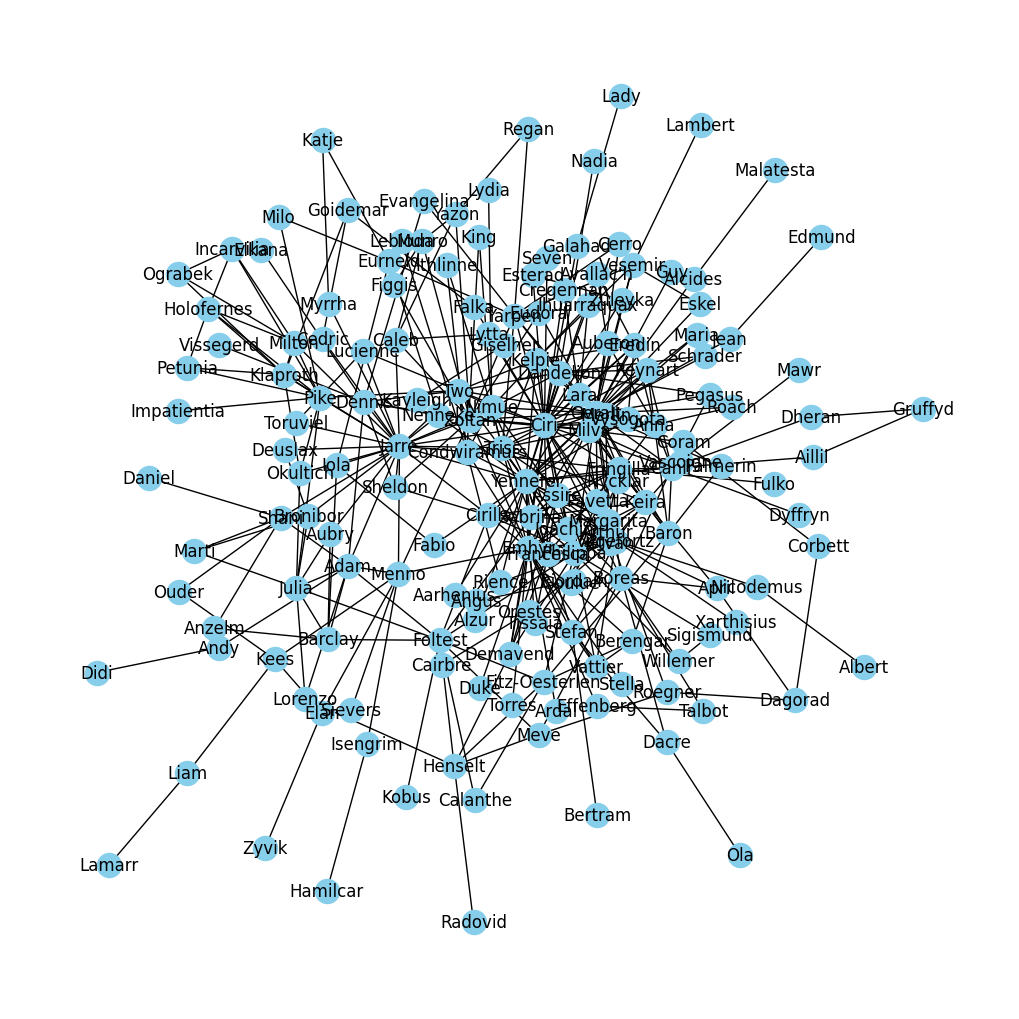

In [52]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Graph visualization - Pyvis

In [55]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.2 MB/s eta 0:00:00


In [56]:
from pyvis.network import Network
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("witcher.html")

witcher.html


# The most important characters in The Witcher

In [57]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Arthur': 0.005952380952380952,
 'Merlin': 0.005952380952380952,
 'Galahad': 0.011904761904761904,
 'Lady': 0.005952380952380952,
 'Condwiramurs': 0.06547619047619047,
 'Lebioda': 0.005952380952380952,
 'Nimue': 0.07738095238095238,
 'Two': 0.06547619047619047,
 'Ciri': 0.23809523809523808,
 'Geralt': 0.22619047619047616,
 'Cahir': 0.08333333333333333,
 'Yennefer': 0.17261904761904762,
 'Pavetta': 0.05357142857142857,
 'Assire': 0.05952380952380952,
 'Lydia': 0.005952380952380952,
 'Emhyr': 0.125,
 'Vattier': 0.02976190476190476,
 'Stella': 0.005952380952380952,
 'Vilgefortz': 0.11309523809523808,
 'Jarre': 0.1607142857142857,
 'Anna': 0.05952380952380952,
 'Milva': 0.07142857142857142,
 'Fringilla': 0.10119047619047619,
 'Rience': 0.017857142857142856,
 'Stefan': 0.041666666666666664,
 'Reynart': 0.03571428571428571,
 'Roach': 0.011904761904761904,
 'Dandelion': 0.07142857142857142,
 'Alcides': 0.011904761904761904,
 'Malatesta': 0.005952380952380952,
 'Jean': 0.011904761904761904,
 

<Axes: >

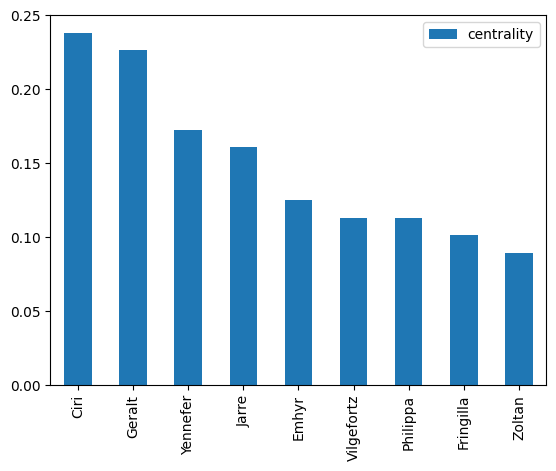

In [58]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

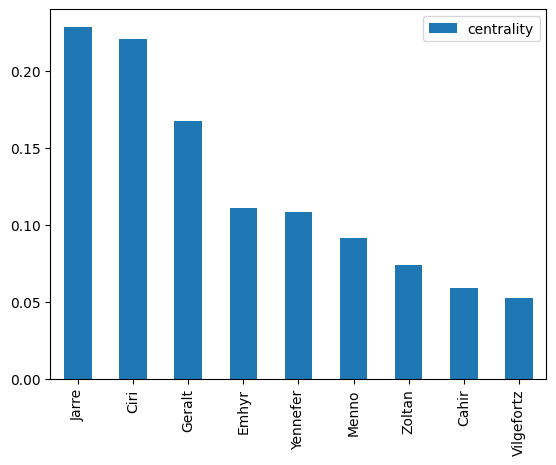

In [59]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

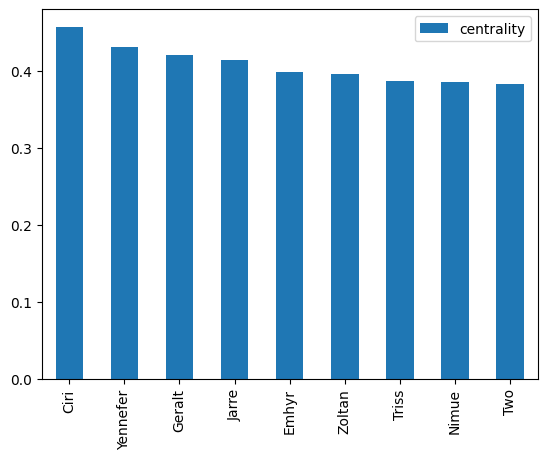

In [60]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [61]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

## Community detection

In [62]:
import community as community_louvain

In [63]:
communities = community_louvain.best_partition(G)

In [72]:
communities

{'Arthur': 0,
 'Merlin': 0,
 'Galahad': 1,
 'Lady': 1,
 'Condwiramurs': 2,
 'Lebioda': 2,
 'Nimue': 2,
 'Two': 2,
 'Ciri': 1,
 'Geralt': 1,
 'Cahir': 1,
 'Yennefer': 3,
 'Pavetta': 1,
 'Assire': 3,
 'Lydia': 2,
 'Emhyr': 4,
 'Vattier': 4,
 'Stella': 4,
 'Vilgefortz': 3,
 'Jarre': 2,
 'Anna': 1,
 'Milva': 1,
 'Fringilla': 3,
 'Rience': 3,
 'Stefan': 4,
 'Reynart': 1,
 'Roach': 1,
 'Dandelion': 1,
 'Alcides': 1,
 'Malatesta': 1,
 'Jean': 1,
 'Baron': 1,
 'Palmerin': 1,
 'Fulko': 3,
 'Philippa': 3,
 'Keira': 3,
 'Margarita': 3,
 'Sabrina': 3,
 'Francesca': 3,
 'Maria': 1,
 'Joachim': 3,
 'Ardal': 4,
 'Cirilla': 5,
 'April': 6,
 'Triss': 3,
 'Guy': 1,
 'Pegasus': 1,
 'Vysogota': 1,
 'Kelpie': 1,
 'Lara': 1,
 "Avallac'h": 1,
 'Cregennan': 1,
 'Vesemir': 1,
 'Eredin': 1,
 'Auberon': 1,
 'Giselher': 7,
 'Kayleigh': 7,
 'Ihuarraquax': 1,
 'Seven': 1,
 'Okultich': 2,
 'Milton': 2,
 'Pike': 2,
 'Klaproth': 2,
 'Nenneke': 3,
 'Ograbek': 2,
 'Goidemar': 2,
 'Falka': 2,
 'Cedric': 2,
 'Adam': 8,
 '

In [65]:
nx.set_node_attributes(G, communities, 'group')

In [66]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

witcher_communities.html


# Evolution of characters' importance

In [75]:
# from lib.utils.functions import * 

# These below functions normally must be in utils folder. But we are working on kaggle
import pandas as pd
import numpy as np
import os
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt


def ner(file_name):
    """
    Function to process text from a text file (.txt) using Spacy.
    
    Params:
    file_name -- name of a txt file as string
    
    Returns:
    a processed doc file using Spacy English language model
    
    """
    # Load spacy English languague model
    nlp = spacy.load("en_core_web_sm")
    book_text = open(file_name).read()
    book_doc = nlp(book_text)
    
    return book_doc


def get_ne_list_per_sentence(spacy_doc):
    """
    Get a list of entites per sentence of a Spacy document and store in a dataframe.
    
    Params:
    spacy_doc -- a Spacy processed document
    
    Returns:
    a dataframe containing the sentences and corresponding list of recognised named entities       in the sentences
    """
    
    sent_entity_df = []

    # Loop through sentences, store named entity list for each sentence
    for sent in spacy_doc.sents:
        entity_list = [ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})

    sent_entity_df = pd.DataFrame(sent_entity_df)
    
    return sent_entity_df


def filter_entity(ent_list, character_df):
    """
    Function to filter out non-character entities.
    
    Params:
    ent_list -- list of entities to be filtered
    character_df -- a dataframe contain characters' names and characters' first names
    
    Returns:
    a list of entities that are characters (matching by names or first names).
    
    """
    return [ent for ent in ent_list 
            if ent in list(character_df.character) 
            or ent in list(character_df.character_firstname)]


def create_relationships(df, window_size):
    
    """
    Create a dataframe of relationships based on the df dataframe (containing lists of chracters per sentence) and the window size of n sentences.
    
    Params:
    df -- a dataframe containing a column called character_entities with the list of chracters for each sentence of a document.
    window_size -- size of the windows (number of sentences) for creating relationships between two adjacent characters in the text.
    
    Returns:
    a relationship dataframe containing 3 columns: source, target, value.
    
    """
    
    relationships = []

    for i in range(df.index[-1]):
        end_i = min(i + window_size, df.index[-1])
        char_list = sum((df.loc[i: end_i].character_entities), [])

        # Remove duplicated characters that are next to each other
        char_unique = [char_list[i] for i in range(len(char_list)) 
                       if (i==0) or char_list[i] != char_list[i-1]]

        if len(char_unique) > 1:
            for idx, a in enumerate(char_unique[:-1]):
                b = char_unique[idx + 1]
                relationships.append({"source": a, "target": b})
           
    relationship_df = pd.DataFrame(relationships)
    # Sort the cases with a->b and b->a
    relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), 
                                   columns = relationship_df.columns)
    relationship_df["value"] = 1
    relationship_df = relationship_df.groupby(["source","target"], 
                                              sort=False, 
                                              as_index=False).sum()
                
    return relationship_df

In [76]:
# Initialize empty list for graphs from books
books_graph = []
all_books = [b for b in os.scandir("/kaggle/input/witcher-books/data") if '.txt' in b.name]
# Load spacy English languague model
nlp = spacy.load("en_core_web_sm")

# Sort dir entries by name
all_books.sort(key=lambda x: x.name)

In [77]:
# Loop through book list and create graphs
for book in all_books:
    book_text = ner(book)
    
    # Get list of entities per sentences
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
    
    # Take only first name of characters
    sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

    # Create relationship df
    relationship_df = create_relationships(df = sent_entity_df_filtered, window_size = 5)                                                                                                               
    
    # Create a graph from a pandas dataframe
    G = nx.from_pandas_edgelist(relationship_df, 
                                source = "source", 
                                target = "target", 
                                edge_attr = "value", 
                                create_using = nx.Graph())     
    
    books_graph.append(G) 

/tmp/ipykernel_32/4223697425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
/tmp/ipykernel_32/4223697425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['character_entities'] = sent_entity_df_filtered['character_entities'].apply(lambda x: [item.split()[0]
/tmp/ipykernel_32/4223697425.py:15: SettingWithCopyWarning: 
A value is trying to be set on a 

<Axes: >

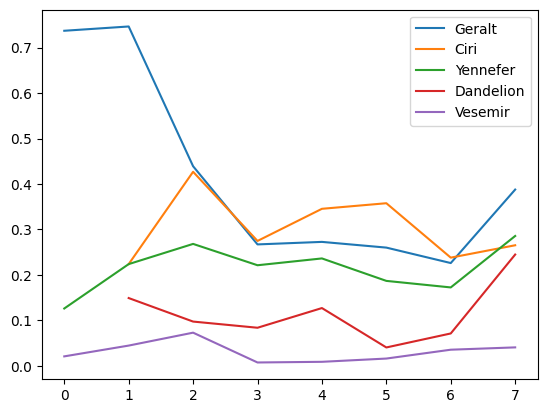

In [78]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Geralt", "Ciri", "Yennefer", "Dandelion", "Vesemir"]].plot()